In [1]:
import numpy as np

from matplotlib import pyplot as plt
from tqdm import tqdm

%matplotlib inline

In [2]:
class Input(object):
    def __init__(self,input_shape):
        self.input_shape = input_shape
        pass
    
    def forward(self,x):
        if x.shape != self.input_shape:
            raise Exception('Exception: x.shape != self.input_shape')
        return x
    
    def __rep__(self):
        return "{0}".format(self.__class__)
    
    def __str__(self):
        return "Input shape : {0}".format(self.input_shape)

In [3]:
class Dense(object):
    def __init__(self,inputs, units, activation, learning_rate=None):
        self.activation = activation
        self.inputs = inputs
        self.units = units
        
        self.weights = np.random.rand(inputs,units)
        
        if learning_rate is None:
            learning_rate = 0.5
        self.learning_rate = learning_rate
        pass
    
    def forward(self,x):
        self.activated = self.activation((np.dot(self.weights.T,x)))
        return self.activated
    
    def update(self,x):
        self.weights -= x*self.learning_rate
        pass
    
    def __rep__(self):
        return "{0}".format(self.__class__)
    
    def __str__(self):
        return "{0}".format(self.weights.shape)

In [4]:
class Model(object):
    def __init__(self, layers=[],placeholder=None):
        self.placeholder = placeholder
        self.layers = layers
        pass
    
    def add(self,layer=None):
        self.layers.append(layer)
        pass
    
    def fit(self,x,labels,epochs,loss, optimizer):
        history = []
        
        input_layer  = self.layers[0]
        hidden_layer = self.layers[1]
        output_layer = self.layers[2]
        
        for _ in tqdm(range(epochs)):
            total_cost = 0.0
            for i in range(len(x_train)):
                xx = np.array(x[i])
                yy = np.array(labels[i])
                
                # Forward propagation
                signals = self.forward(xx)
                
                # Backpropagation
                cost, weights = self.backpropagation(yy,loss,optimizer,signals)
                
                total_cost += cost
                # Update weights
                self.update(weights)
                
            history.append(total_cost/len(x_train))
            
        return history
    
    def forward(self, x):
        signals = []
        y = x
        for layer in self.layers:
            y = layer.forward(y)
            signals.append(y)
        return signals
    
    def backpropagation(self,expected,loss,optimizer,signals=[]):
        weights = []
        # Cost
        last = (len(self.layers)-1)
        y_pred = signals[last]
        diff = (y_pred-expected)
        cost = loss(diff)
                
        # Back propagation
        common = ((diff)*optimizer(y_pred)).T
        weights.append(np.dot(signals[last-1],common))
        
        for i in range((last-2),-1,-1):
            common = np.dot(common,self.layers[i+2].weights.T)*optimizer(signals[i+1].T)
            w = np.dot(signals[i],(common))
            weights.append(w)
        return cost, reversed(weights)
    
    def update(self,weights):
        for i,weight in enumerate(weights):
            self.layers[i+1].update(weight)
        pass
    
    def predict(self,x):
        return self.forward(x)[(len(self.layers)-1)]
    
    def evaluate(self,x,labels):
        correct = 0
        for i,j in enumerate(x):
            pred = model.predict(j)
            indx = np.argmax(pred)
            indy = np.argmax(labels[i])
            if indx == indy:
                correct += 1
        return correct/len(x)
    
    def __rep__(self):
        return "{0}".format(self.__class__)
    
    def __str__(self):
        return "Layers : {0}".format(self.layers)

In [5]:
# Activation function(s)
def sigmoid(z):
    return 1.0/(1.0+np.exp(-z))

def sigmoid_prime(z):
    return z*(1.0-z)

def tanh(z):
    return np.tanh(z)

def tanh_prime(z):
    return 1.0 - z**2

def softmax(z):
    return np.exp(z)/np.sum(np.exp(z))

def relu(z):
    return np.max(0,z)

# Loss function(s)
def rmse(x):
    return np.sum(np.square(x)/2)

# Data preprocessing

In [6]:
from sklearn.datasets import load_iris

iris = load_iris()

In [7]:
categories = np.array([[1,0,0],[0,1,0],[0,0,1]])

x_pre_train = np.array([m.reshape(4,1) for m in iris.data])
y_pre_train = np.array([categories[m].reshape(3,1) for m in iris.target])

train_data = np.array([[i,j] for i,j in zip(x_pre_train,y_pre_train)])
np.random.shuffle(train_data)

x_train = np.asarray([i[0] for i in train_data[:-40]])
y_train = np.asarray([i[1] for i in train_data[:-40]])

x_test = np.asarray([i[0] for i in train_data[110:]])
y_test = np.asarray([i[1] for i in train_data[110:]])

# Build model

In [8]:
model = Model()

model.add(Input(input_shape=(4,1)))
model.add(Dense(inputs=4, units=9, activation=sigmoid))
model.add(Dense(inputs=9, units=4, activation=sigmoid))
model.add(Dense(inputs=4, units=3, activation=sigmoid))

# Training

In [9]:
yy = model.fit(x=x_train, labels=y_train, epochs=500,loss=rmse, optimizer=sigmoid_prime)

100%|██████████| 500/500 [00:02<00:00, 208.42it/s]


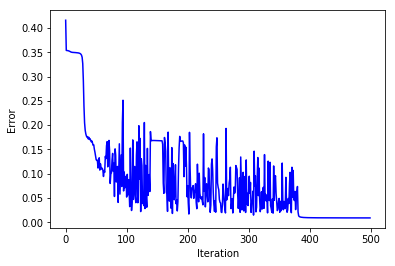

In [10]:
plt.figure()
plt.plot(yy,color = 'b')
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.show()

# Evaluation

In [11]:
model.evaluate(x_test,y_test)

0.925

# Prediction

In [12]:
pred = model.predict(np.array([[5.1],
        [3.5],
        [1.4],
        [0.2]]))
m = np.argmax(softmax(pred))
print(iris.target_names[np.argmax(pred)], pred[m])         # We are expecting setosa

setosa [0.99686598]


In [13]:
pred = model.predict(np.array([[7.0],
        [3.2],
        [4.7],
        [1.4]]))
m = np.argmax(softmax(pred))
print(iris.target_names[m], pred[m])                       # We are expecting versicolor

versicolor [0.98192244]
